In [9]:
# ===== 0) 환경 설정 및 Import =====
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

print("환경 설정 완료")

환경 설정 완료


In [10]:
# ===== 1) 설정 =====
DATA_PATH = "/home/yu_mcc/QR_Phishing/phishing/phishing_data_tflite_ready.csv"
TARGET_COL = "status"
RANDOM_SEED = 42

# 시드 설정
np.random.seed(RANDOM_SEED)

print(f"설정 완료: RANDOM_SEED={RANDOM_SEED}")

설정 완료: RANDOM_SEED=42


In [11]:
# ===== 2) 데이터 로드 및 전처리 =====
df = pd.read_csv(DATA_PATH)
print(f"데이터 shape: {df.shape}")
print(f"\n컬럼 목록:\n{df.columns.tolist()}")
print(f"\n처음 5행:\n{df.head()}")

# 타겟 변수 확인
print(f"\n타겟 변수 ({TARGET_COL}) 분포:")
print(df[TARGET_COL].value_counts())

데이터 shape: (11481, 55)

컬럼 목록:
['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'shortening_service', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'nb_extCSS', 'login_form', 'popup_window', 'empty_title', 'domain_in_title', 'domain_with_copyright', 'status']

처음 5행:
   length_url  length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  \
0   

In [12]:
# ===== 3) 피처 및 레이블 분리 (50:50 균형 분할) =====
# 원본 데이터 보존을 위해 복사본 사용
df_work = df.copy()

# 'id' 컬럼이 있다면 제거
if 'id' in df_work.columns:
    df_work = df_work.drop(columns=['id'])

# 타겟 변수 그대로 사용
# status: 0 = 정상, 1 = 피싱
print(f"피처 개수: {len(df_work.columns) - 1}")
print(f"전체 데이터 shape: {df_work.shape}")
print(f"\n원본 레이블 분포:")
print(f"  - 정상(0): {(df_work[TARGET_COL]==0).sum()}")
print(f"  - 피싱(1): {(df_work[TARGET_COL]==1).sum()}")

# ===== 50:50 균형 분할 함수 =====
def split_class(class_df, train_ratio=0.6, val_ratio=0.2, seed=42):
    """클래스별로 train/val/test 분할"""
    # 여러 번 셔플해서 패턴 편향 방지
    shuffled = class_df.sample(frac=1, random_state=seed)
    shuffled = shuffled.sample(frac=1, random_state=seed+1)
    shuffled = shuffled.sample(frac=1, random_state=seed+2)
    
    n = len(shuffled)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    return (shuffled.iloc[:train_end], 
            shuffled.iloc[train_end:val_end], 
            shuffled.iloc[val_end:])

# 클래스별로 분리
df_legit = df_work[df_work[TARGET_COL] == 0]  # 정상
df_phish = df_work[df_work[TARGET_COL] == 1]  # 피싱

# 각 클래스별로 60/20/20 분할
legit_train, legit_val, legit_test = split_class(df_legit, seed=RANDOM_SEED)
phish_train, phish_val, phish_test = split_class(df_phish, seed=RANDOM_SEED)

# 합치기 (각 세트에서 50:50 비율 유지)
train_df = pd.concat([legit_train, phish_train]).sample(frac=1, random_state=RANDOM_SEED)
val_df = pd.concat([legit_val, phish_val]).sample(frac=1, random_state=RANDOM_SEED)
test_df = pd.concat([legit_test, phish_test]).sample(frac=1, random_state=RANDOM_SEED)

# 피처와 레이블 분리
X_train = train_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_train = train_df[TARGET_COL].values.astype(np.float32)

X_val = val_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_val = val_df[TARGET_COL].values.astype(np.float32)

X_test = test_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_test = test_df[TARGET_COL].values.astype(np.float32)

# 결과 출력
print(f"\n===== 50:50 균형 분할 결과 =====")
print(f"Train: {X_train.shape} - 정상:{(y_train==0).sum()}, 피싱:{(y_train==1).sum()}")
print(f"Val:   {X_val.shape} - 정상:{(y_val==0).sum()}, 피싱:{(y_val==1).sum()}")
print(f"Test:  {X_test.shape} - 정상:{(y_test==0).sum()}, 피싱:{(y_test==1).sum()}")

# 비율 확인
print(f"\n===== 각 세트의 피싱 비율 =====")
print(f"Train 피싱 비율: {y_train.mean()*100:.1f}%")
print(f"Val 피싱 비율:   {y_val.mean()*100:.1f}%")
print(f"Test 피싱 비율:  {y_test.mean()*100:.1f}%")

피처 개수: 54
전체 데이터 shape: (11481, 55)

원본 레이블 분포:
  - 정상(0): 5740
  - 피싱(1): 5741

===== 50:50 균형 분할 결과 =====
Train: (6888, 54) - 정상:3444, 피싱:3444
Val:   (2296, 54) - 정상:1148, 피싱:1148
Test:  (2297, 54) - 정상:1148, 피싱:1149

===== 각 세트의 피싱 비율 =====
Train 피싱 비율: 50.0%
Val 피싱 비율:   50.0%
Test 피싱 비율:  50.0%


In [13]:
# ===== 4) 데이터 전처리 (RobustScaler - embedding_model과 동일) =====
from sklearn.preprocessing import RobustScaler

# RobustScaler를 적용할 피처 목록 (이상치가 많은 피처들)
robust_cols = [
    'length_url',
    'length_hostname',
    'nb_dots',
    'nb_hyphens',
    'nb_and',
    'nb_eq',
    'nb_underscore',
    'nb_percent',
    'nb_slash',
    'nb_colon',
    'nb_semicolumn',
    'nb_space',
    'nb_com',
    'ratio_digits_url',
    'ratio_digits_host',
    'length_words_raw',
    'char_repeat',
    'shortest_words_raw',
    'shortest_word_host',
    'shortest_word_path',
    'longest_words_raw',
    'longest_word_host',
    'longest_word_path',
    'avg_words_raw',
    'avg_word_host',
    'avg_word_path',
    'phish_hints',
    'nb_extCSS',
]

# 피처 인덱스 매핑
feature_names = [col for col in df_work.columns if col != TARGET_COL]
robust_indices = [feature_names.index(col) for col in robust_cols if col in feature_names]
raw_indices = [i for i in range(len(feature_names)) if i not in robust_indices]

print(f"RobustScaler 적용 피처: {len(robust_indices)}개")
print(f"정규화 없음 (원본 그대로): {len(raw_indices)}개")

# RobustScaler 생성
robust_scaler = RobustScaler()

# 스케일링 수행
X_train_scaled = X_train.copy().astype(np.float32)
X_val_scaled = X_val.copy().astype(np.float32)
X_test_scaled = X_test.copy().astype(np.float32)

# RobustScaler 적용만 (중앙값 기반 - 이상치 영향 적음)
X_train_scaled[:, robust_indices] = robust_scaler.fit_transform(X_train[:, robust_indices]).astype(np.float32)
X_val_scaled[:, robust_indices] = robust_scaler.transform(X_val[:, robust_indices]).astype(np.float32)
X_test_scaled[:, robust_indices] = robust_scaler.transform(X_test[:, robust_indices]).astype(np.float32)

# raw_indices는 그대로 두기 (정규화 안 함)

print("\n데이터 전처리 완료 (RobustScaler - embedding_model과 동일)")
print(f"Train 피처 범위: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")
print(f"Train 피처 평균: {X_train_scaled.mean():.4f}, 표준편차: {X_train_scaled.std():.4f}")
print(f"피처 개수: {X_train_scaled.shape[1]}개")

RobustScaler 적용 피처: 28개
정규화 없음 (원본 그대로): 26개

데이터 전처리 완료 (RobustScaler - embedding_model과 동일)
Train 피처 범위: min=-2.00, max=124.00
Train 피처 평균: 0.2513, 표준편차: 1.0752
피처 개수: 54개


In [14]:
# ===== 5) 랜덤 포레스트 모델 학습 =====
print("랜덤 포레스트 모델 학습 시작...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1
)

# 학습
rf_model.fit(X_train_scaled, y_train)

print(f"✅ 랜덤 포레스트 모델 학습 완료!")
print(f"   트리 개수: {rf_model.n_estimators}")
print(f"   동적 중지도: {rf_model.max_depth}")
print(f"   클래스: {rf_model.classes_}")

랜덤 포레스트 모델 학습 시작...
✅ 랜덤 포레스트 모델 학습 완료!
   트리 개수: 100
   동적 중지도: 10
   클래스: [0. 1.]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [15]:
# ===== 분할 검증 (데이터 손실/중복 확인) =====
print("\n" + "="*60)
print("분할 검증")
print("="*60)

# 1) 데이터 중복/손실 확인
total_samples = len(X_train) + len(X_val) + len(X_test)
print(f"\n1️⃣ 데이터 무결성 확인:")
print(f"   Train + Val + Test = {total_samples}")
print(f"   원본 데이터 = {len(X_train_scaled) + len(X_val_scaled) + len(X_test_scaled)}")
print(f"   ✅ 일치" if total_samples == len(df_work) else f"   ❌ 불일치")

# 2) 비율 확인
print(f"\n2️⃣ 분할 비율 확인 (60:20:20):")
print(f"   Train: {len(X_train)} ({len(X_train)/len(df_work)*100:.1f}%)")
print(f"   Val:   {len(X_val)} ({len(X_val)/len(df_work)*100:.1f}%)")
print(f"   Test:  {len(X_test)} ({len(X_test)/len(df_work)*100:.1f}%)")

# 3) 클래스 균형 확인
print(f"\n3️⃣ 클래스 균형 확인 (각 세트 50:50):")
for name, y in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    legit_count = (y==0).sum()
    phish_count = (y==1).sum()
    legit_ratio = legit_count / len(y) * 100
    phish_ratio = phish_count / len(y) * 100
    print(f"   {name}: 정상 {legit_count}({legit_ratio:.1f}%), 피싱 {phish_count}({phish_ratio:.1f}%)")

print("\n" + "="*60)


분할 검증

1️⃣ 데이터 무결성 확인:
   Train + Val + Test = 11481
   원본 데이터 = 11481
   ✅ 일치

2️⃣ 분할 비율 확인 (60:20:20):
   Train: 6888 (60.0%)
   Val:   2296 (20.0%)
   Test:  2297 (20.0%)

3️⃣ 클래스 균형 확인 (각 세트 50:50):
   Train: 정상 3444(50.0%), 피싱 3444(50.0%)
   Val: 정상 1148(50.0%), 피싱 1148(50.0%)
   Test: 정상 1148(50.0%), 피싱 1149(50.0%)



In [16]:
# ===== 6) 모델 평가 =====
print("="*60)
print("모델 평가 (Test Set)")
print("="*60)

# 예측
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# 메트릭 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 성능 메트릭:")
print(f"  - Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall:    {recall:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"  - AUC-ROC:   {auc_roc:.4f}")

print(f"\n📋 분류 리포트:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

모델 평가 (Test Set)

📊 성능 메트릭:
  - Accuracy:  0.9108 (91.08%)
  - Precision: 0.9041
  - Recall:    0.9191
  - F1 Score:  0.9115
  - AUC-ROC:   0.9711

📋 분류 리포트:
              precision    recall  f1-score   support

  Legitimate       0.92      0.90      0.91      1148
    Phishing       0.90      0.92      0.91      1149

    accuracy                           0.91      2297
   macro avg       0.91      0.91      0.91      2297
weighted avg       0.91      0.91      0.91      2297



[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


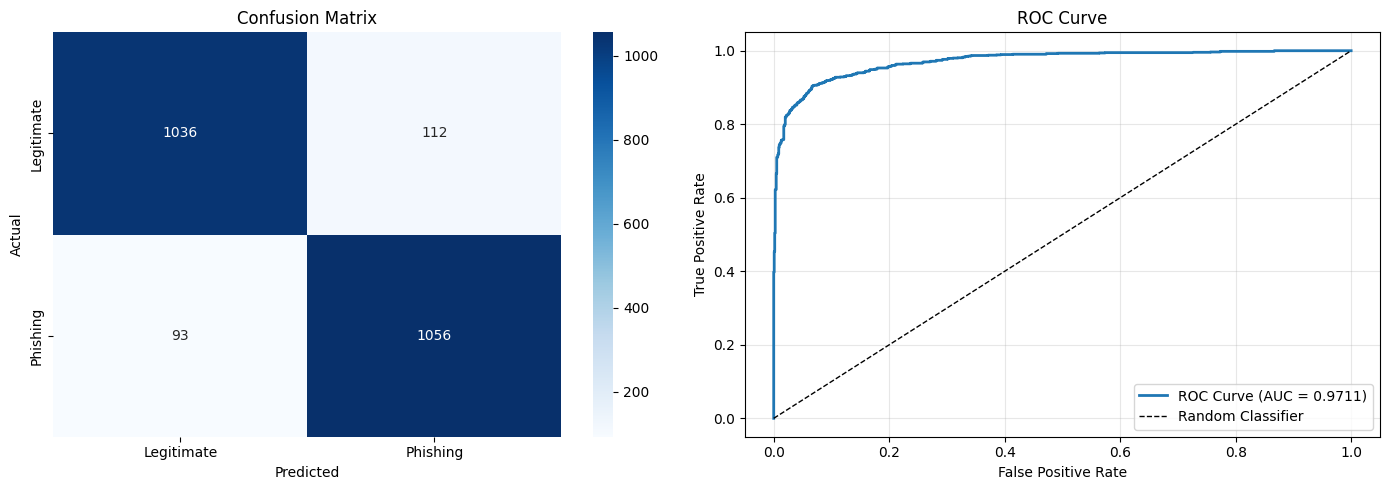

In [17]:
# ===== 7) 시각화 (Confusion Matrix, ROC Curve) =====
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.4f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🎯 최적 임계값 분석

📊 임계값별 F1 Score (상위 10개):
   Threshold 0.55: F1 = 0.9159 ⭐ BEST
   Threshold 0.50: F1 = 0.9115 (기본값)
   Threshold 0.45: F1 = 0.9055
   Threshold 0.60: F1 = 0.9039
   Threshold 0.40: F1 = 0.8971
   Threshold 0.65: F1 = 0.8925
   Threshold 0.35: F1 = 0.8869
   Threshold 0.30: F1 = 0.8693
   Threshold 0.70: F1 = 0.8543
   Threshold 0.25: F1 = 0.8525

✅ 최적 임계값: 0.55
   - F1 Score: 0.9159
   - Accuracy: 0.9173
   - Precision: 0.9316
   - Recall: 0.9008

📌 기본 임계값 0.5 성능:
   - F1 Score: 0.9115
   - Accuracy: 0.9108


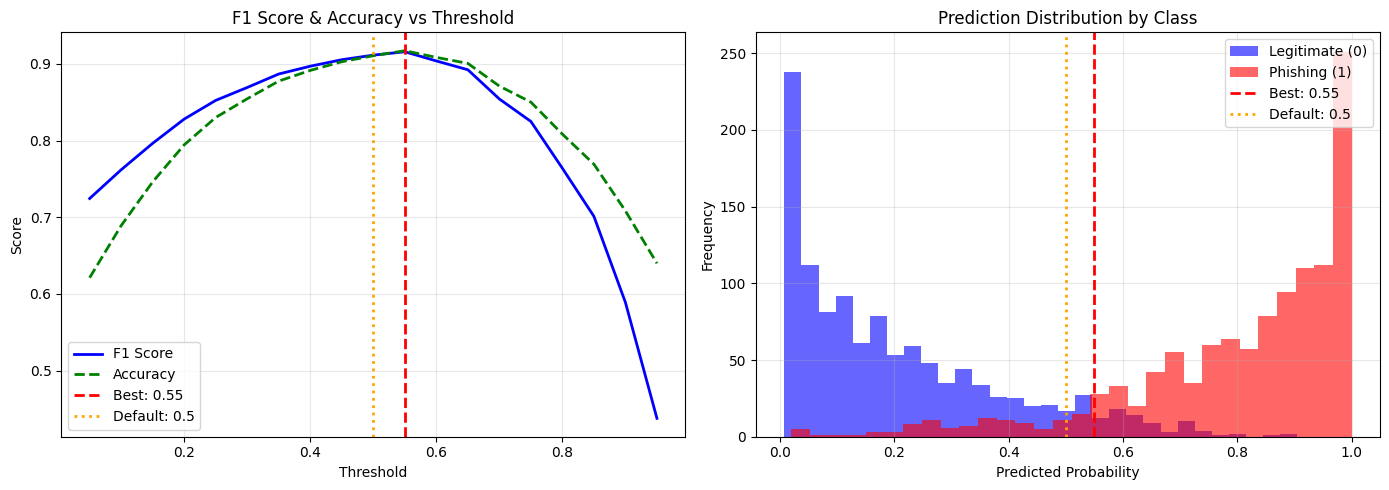


📝 결론
✅ 0.5와 최적 임계값 차이가 0.05로 작고, F1 개선도 0.0044로 미미합니다.
   → 기본값 0.5 사용해도 됩니다.

🎯 최종 사용 임계값: 0.5


In [18]:
# ===== 8) 최적 임계값 분석 =====
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

print("="*60)
print("🎯 최적 임계값 분석")
print("="*60)

# 다양한 임계값에서 F1 Score 계산 (0.05 ~ 0.95)
thresholds_to_test = np.arange(0.05, 1.0, 0.05)
f1_scores = []
accuracies = []
precisions = []
recalls = []

for thresh in thresholds_to_test:
    pred_binary = (y_pred_proba > thresh).astype(int)
    f1 = f1_score(y_test, pred_binary)
    acc = accuracy_score(y_test, pred_binary)
    prec = precision_score(y_test, pred_binary, zero_division=0)
    rec = recall_score(y_test, pred_binary, zero_division=0)
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)

# 최적 임계값 찾기 (F1 기준)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds_to_test[best_idx]
best_f1 = f1_scores[best_idx]

# 기본 0.5 성능
default_f1 = f1_score(y_test, (y_pred_proba > 0.5).astype(int))
default_acc = accuracy_score(y_test, (y_pred_proba > 0.5).astype(int))

print(f"\n📊 임계값별 F1 Score (상위 10개):")
sorted_indices = np.argsort(f1_scores)[::-1][:10]
for idx in sorted_indices:
    thresh = thresholds_to_test[idx]
    f1 = f1_scores[idx]
    marker = " ⭐ BEST" if idx == best_idx else ""
    default_marker = " (기본값)" if abs(thresh - 0.5) < 0.01 else ""
    print(f"   Threshold {thresh:.2f}: F1 = {f1:.4f}{marker}{default_marker}")

print(f"\n✅ 최적 임계값: {best_threshold:.2f}")
print(f"   - F1 Score: {best_f1:.4f}")
print(f"   - Accuracy: {accuracies[best_idx]:.4f}")
print(f"   - Precision: {precisions[best_idx]:.4f}")
print(f"   - Recall: {recalls[best_idx]:.4f}")

print(f"\n📌 기본 임계값 0.5 성능:")
print(f"   - F1 Score: {default_f1:.4f}")
print(f"   - Accuracy: {default_acc:.4f}")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 vs Threshold
axes[0].plot(thresholds_to_test, f1_scores, 'b-', linewidth=2, label='F1 Score')
axes[0].plot(thresholds_to_test, accuracies, 'g--', linewidth=2, label='Accuracy')
axes[0].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, label=f'Best: {best_threshold:.2f}')
axes[0].axvline(x=0.5, color='orange', linestyle=':', linewidth=2, label='Default: 0.5')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('F1 Score & Accuracy vs Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 예측 확률 분포 (클래스별) + 임계값 표시
axes[1].hist(y_pred_proba[y_test==0], bins=30, alpha=0.6, label='Legitimate (0)', color='blue')
axes[1].hist(y_pred_proba[y_test==1], bins=30, alpha=0.6, label='Phishing (1)', color='red')
axes[1].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, label=f'Best: {best_threshold:.2f}')
axes[1].axvline(x=0.5, color='orange', linestyle=':', linewidth=2, label='Default: 0.5')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Distribution by Class')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 결론
diff = abs(best_threshold - 0.5)
f1_improvement = best_f1 - default_f1

print(f"\n" + "="*60)
print("📝 결론")
print("="*60)
if diff < 0.1 and f1_improvement < 0.01:
    print(f"✅ 0.5와 최적 임계값 차이가 {diff:.2f}로 작고, F1 개선도 {f1_improvement:.4f}로 미미합니다.")
    print(f"   → 기본값 0.5 사용해도 됩니다.")
    FINAL_THRESHOLD = 0.5
else:
    print(f"⚠️ 최적 임계값({best_threshold:.2f})이 0.5와 {diff:.2f} 차이납니다.")
    print(f"   F1 개선: {default_f1:.4f} → {best_f1:.4f} (+{f1_improvement:.4f})")
    print(f"   → Android 앱에서 {best_threshold:.2f}를 사용하는 것을 권장합니다.")
    FINAL_THRESHOLD = best_threshold

print(f"\n🎯 최종 사용 임계값: {FINAL_THRESHOLD}")

SHAP 분석 시작 (랜덤 포레스트 모델)
테스트 데이터 shape: (2297, 54)
✅ SHAP 계산 완료!
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (2297, 54, 2)
Feature names count: 54
SHAP values 원본 shape: (2297, 54, 2)
SHAP values 처리 후 shape: (2297, 54)

🔍 DEBUG - 배열 길이 확인:
  - feature_names: 54
  - mean_shap_signed shape: (54,)
  - mean_abs_shap shape: (54,)
  - shap_values original shape: (2297, 54)
✅ Saved: /home/yu_mcc/QR_Phishing/phishing/shap_bar_twocolumn.png


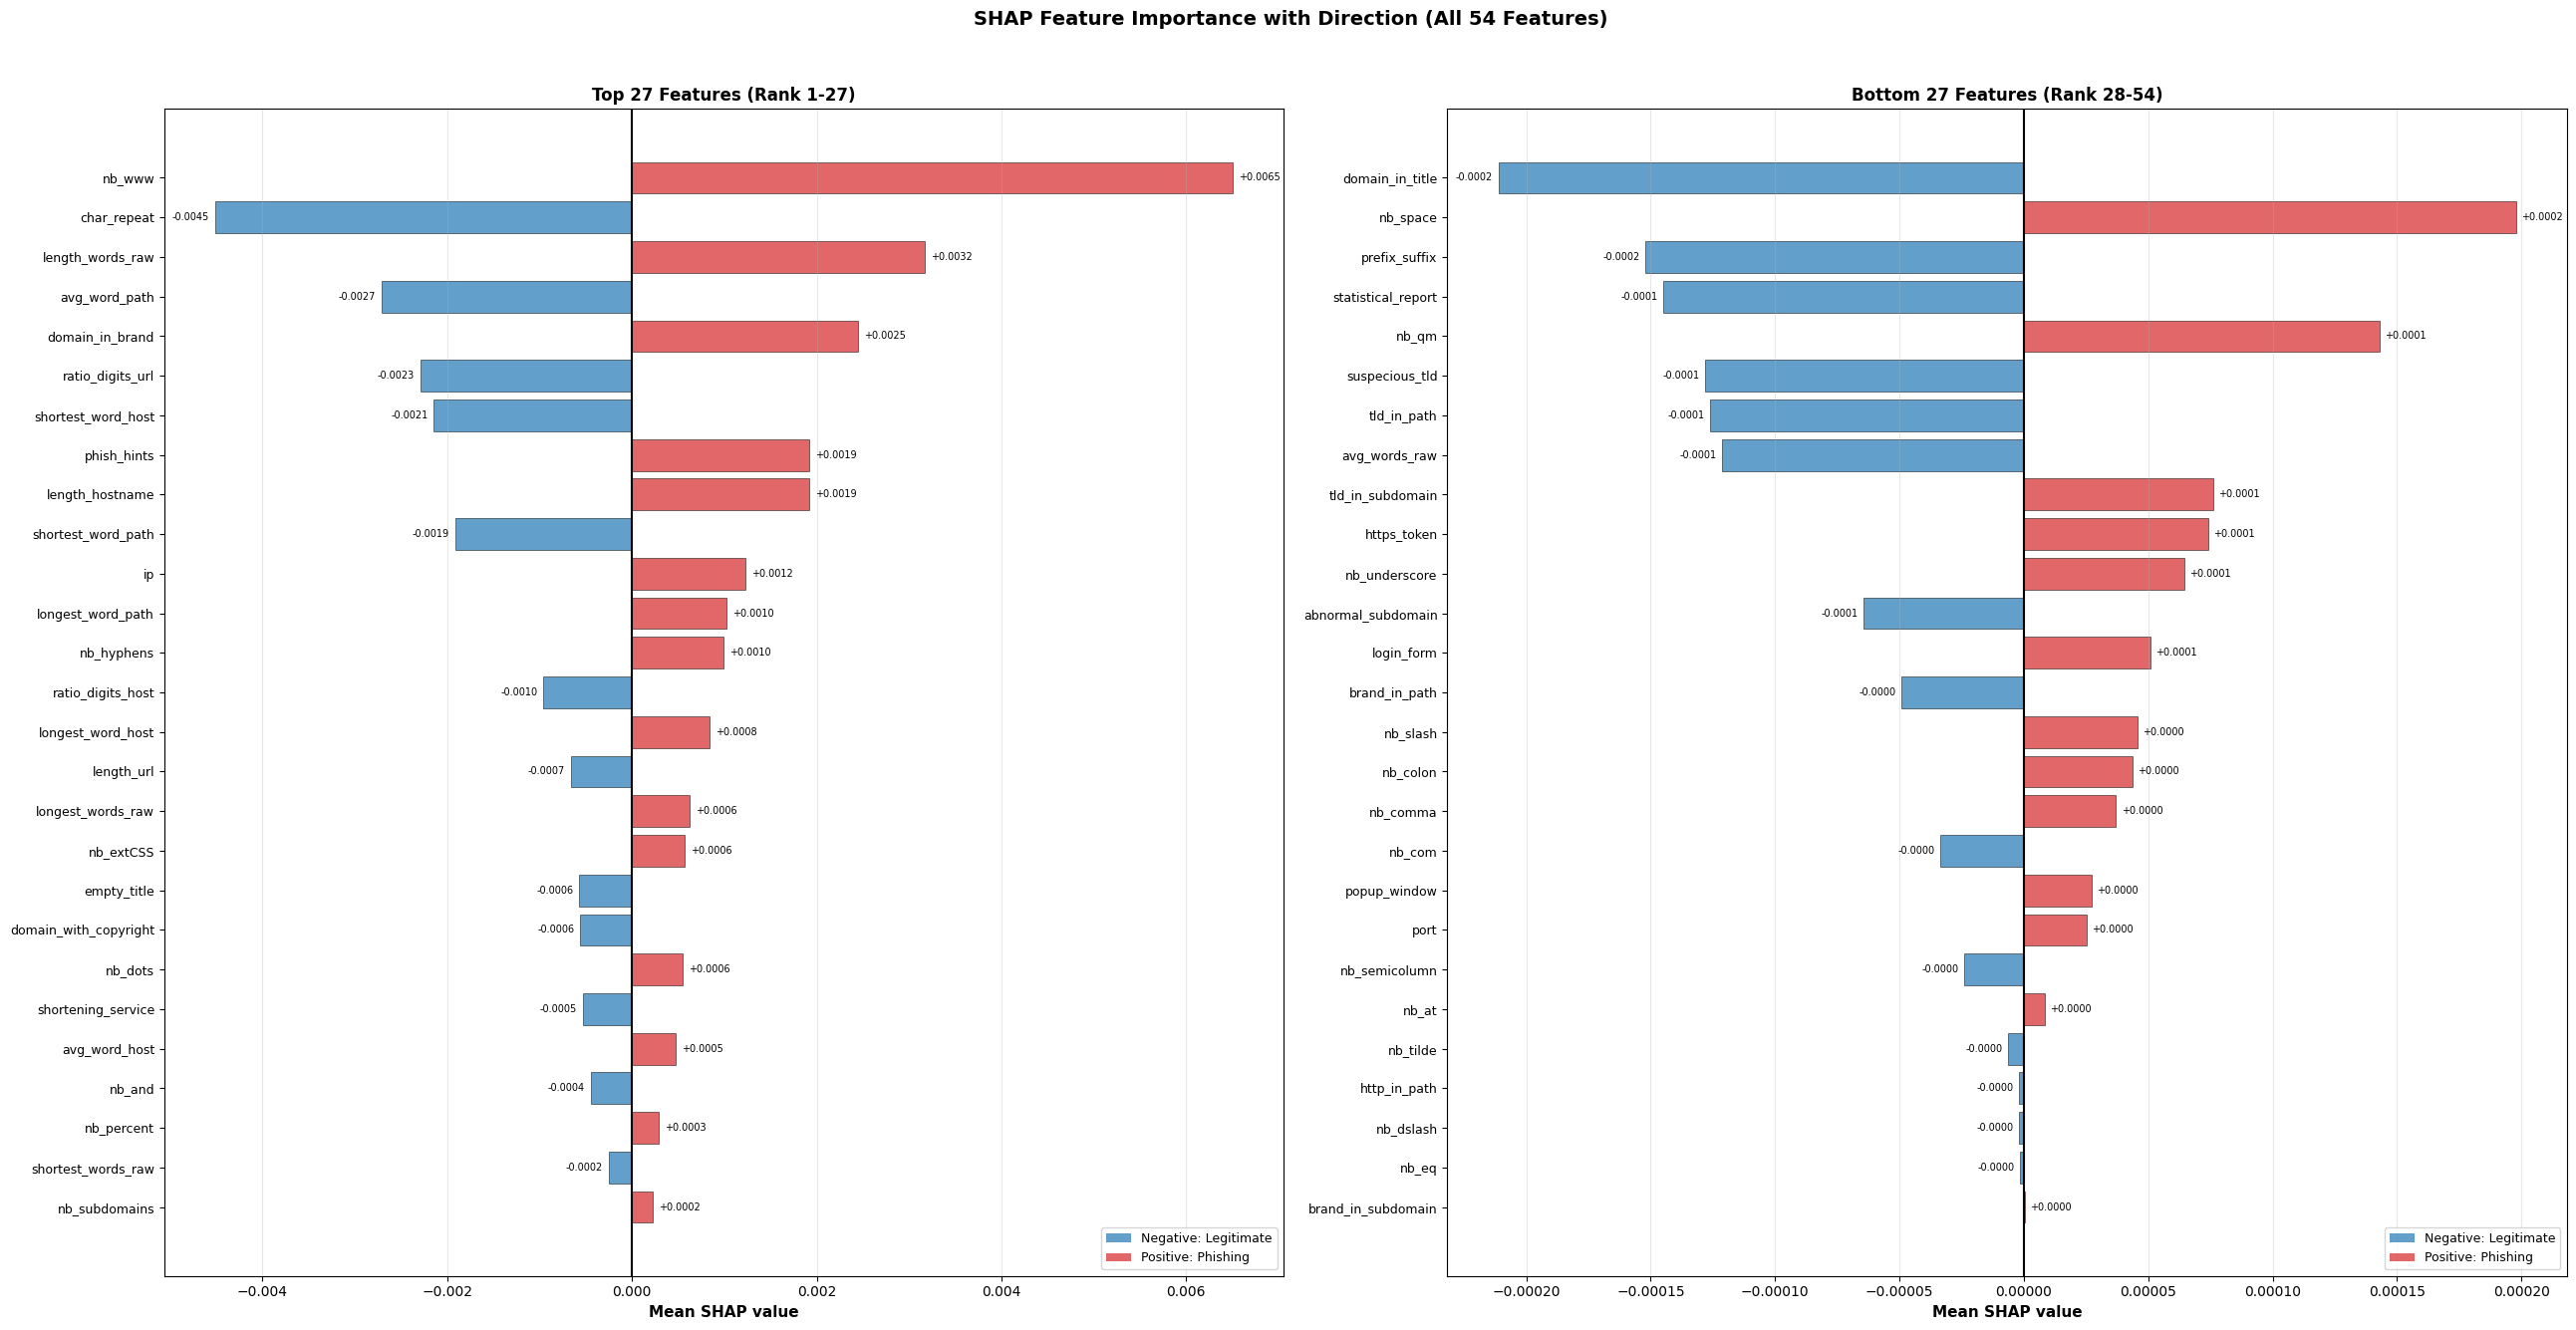


📊 피처 순위 (절대값 기준):
------------------------------------------------------------
 1. nb_www                      0.006502 → Phishing
 2. char_repeat                -0.004512 ← Legitimate
 3. length_words_raw            0.003171 → Phishing
 4. avg_word_path              -0.002708 ← Legitimate
 5. domain_in_brand             0.002451 → Phishing
 6. ratio_digits_url           -0.002288 ← Legitimate
 7. shortest_word_host         -0.002144 ← Legitimate
 8. phish_hints                 0.001916 → Phishing
 9. length_hostname             0.001916 → Phishing
10. shortest_word_path         -0.001912 ← Legitimate
11. ip                          0.001223 → Phishing
12. longest_word_path           0.001022 → Phishing
13. nb_hyphens                  0.000994 → Phishing
14. ratio_digits_host          -0.000960 ← Legitimate
15. longest_word_host           0.000842 → Phishing
16. length_url                 -0.000662 ← Legitimate
17. longest_words_raw           0.000626 → Phishing
18. nb_extCSS         

In [19]:
# ===== 9) SHAP 분석 - 랜덤 포레스트용 =====
import matplotlib.pyplot as plt
import os
import shap

OUTPUT_DIR = "/home/yu_mcc/QR_Phishing/phishing"

print("="*70)
print("SHAP 분석 시작 (랜덤 포레스트 모델)")
print("="*70)

# SHAP TreeExplainer (랜덤 포레스트에 최적화)
explainer = shap.TreeExplainer(rf_model, feature_names=feature_names)
shap_values = explainer.shap_values(X_test_scaled)

print(f"테스트 데이터 shape: {X_test_scaled.shape}")
print(f"✅ SHAP 계산 완료!")
print(f"SHAP values type: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"SHAP values (내비스 클래스): {shap_values[1].shape}")
else:
    print(f"SHAP values shape: {shap_values.shape}")
print(f"Feature names count: {len(feature_names)}")

# Summary plot용 샘플 데이터 준비
X_test_sample = X_test_scaled.copy()

# 랜덤 포레스트는 모든 클래스의 SHAP 값을 반환 (3D: n_samples x n_features x n_classes)
# binary classification인 경우: [:, :, 1]로 positive class 추출
print(f"SHAP values 원본 shape: {shap_values.shape}")

if isinstance(shap_values, list):
    # 가끔 list로 반환되기도 함
    shap_values = shap_values[1]
elif len(shap_values.shape) == 3:
    # 3D 배열 (n_samples, n_features, n_classes)에서 positive class 추출
    shap_values = shap_values[:, :, 1]

print(f"SHAP values 처리 후 shape: {shap_values.shape}")

mean_shap_signed = np.mean(shap_values, axis=0)
mean_abs_shap = np.abs(mean_shap_signed)

if isinstance(mean_shap_signed, np.ndarray) and len(mean_shap_signed.shape) > 1:
    mean_shap_signed = mean_shap_signed.flatten()
    mean_abs_shap = mean_abs_shap.flatten()

# ===== DEBUG: 배열 길이 확인 =====
print(f"\n🔍 DEBUG - 배열 길이 확인:")
print(f"  - feature_names: {len(feature_names)}")
print(f"  - mean_shap_signed shape: {mean_shap_signed.shape if hasattr(mean_shap_signed, 'shape') else len(mean_shap_signed)}")
print(f"  - mean_abs_shap shape: {mean_abs_shap.shape if hasattr(mean_abs_shap, 'shape') else len(mean_abs_shap)}")
print(f"  - shap_values original shape: {shap_values.shape if isinstance(shap_values, np.ndarray) else 'list'}")

# 데이터프레임 생성 (절대값 기준 정렬)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'shap_signed': mean_shap_signed,
    'shap_abs': mean_abs_shap
}).sort_values('shap_abs', ascending=False).reset_index(drop=True)

# 54개를 27개씩 나누기
n_features = len(importance_df)
half = n_features // 2  # 27개

top_half = importance_df.iloc[:half].sort_values('shap_abs', ascending=True)  # 상위 27개
bottom_half = importance_df.iloc[half:].sort_values('shap_abs', ascending=True)  # 하위 27개

# 투컬럼 그래프 생성
fig, axes = plt.subplots(1, 2, figsize=(26, 14))

for ax, data, title in zip(axes, [top_half, bottom_half], 
                            ['Top 27 Features (Rank 1-27)', 'Bottom 27 Features (Rank 28-54)']):
    colors = ['#1f77b4' if x < 0 else '#d62728' for x in data['shap_signed']]
    
    ax.barh(range(len(data)), data['shap_signed'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
    
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data['feature'], fontsize=9)
    ax.set_xlabel('Mean SHAP value', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # 값 표시 (offset을 동적으로 계산)
    x_range = data['shap_abs'].max()
    offset = x_range * 0.01  # 막대 최대값의 1%만큼 offset
    
    for i, (feat, val_signed, val_abs) in enumerate(zip(data['feature'], data['shap_signed'], data['shap_abs'])):
        sign = '+' if val_signed > 0 else ''
        if val_signed < 0:
            ax.text(val_signed - offset, i, f'{val_signed:.4f}', va='center', ha='right', fontsize=7)
        else:
            ax.text(val_signed + offset, i, f'{sign}{val_signed:.4f}', va='center', ha='left', fontsize=7)
    
    # 범례 (각 서브플롯에 배치)
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#1f77b4', alpha=0.7, label='Negative: Legitimate'),
        Patch(facecolor='#d62728', alpha=0.7, label='Positive: Phishing')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.suptitle('SHAP Feature Importance with Direction (All 54 Features)', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(os.path.join(OUTPUT_DIR, 'shap_bar_twocolumn.png'), dpi=300, bbox_inches='tight')
print(f"✅ Saved: {os.path.join(OUTPUT_DIR, 'shap_bar_twocolumn.png')}")
plt.show()

print("\n📊 피처 순위 (절대값 기준):")
print("-"*60)
for rank, (_, row) in enumerate(importance_df.iterrows(), 1):
    direction = '→ Phishing' if row['shap_signed'] > 0 else '← Legitimate'
    print(f"{rank:>2}. {row['feature']:<25} {row['shap_signed']:>10.6f} {direction}")

SHAP Summary Plot (54 Features - 논문용 투컬럼)
SHAP values shape: (2297, 54)


✅ Saved: /home/yu_mcc/QR_Phishing/phishing/shap_summary_twocolumn.png


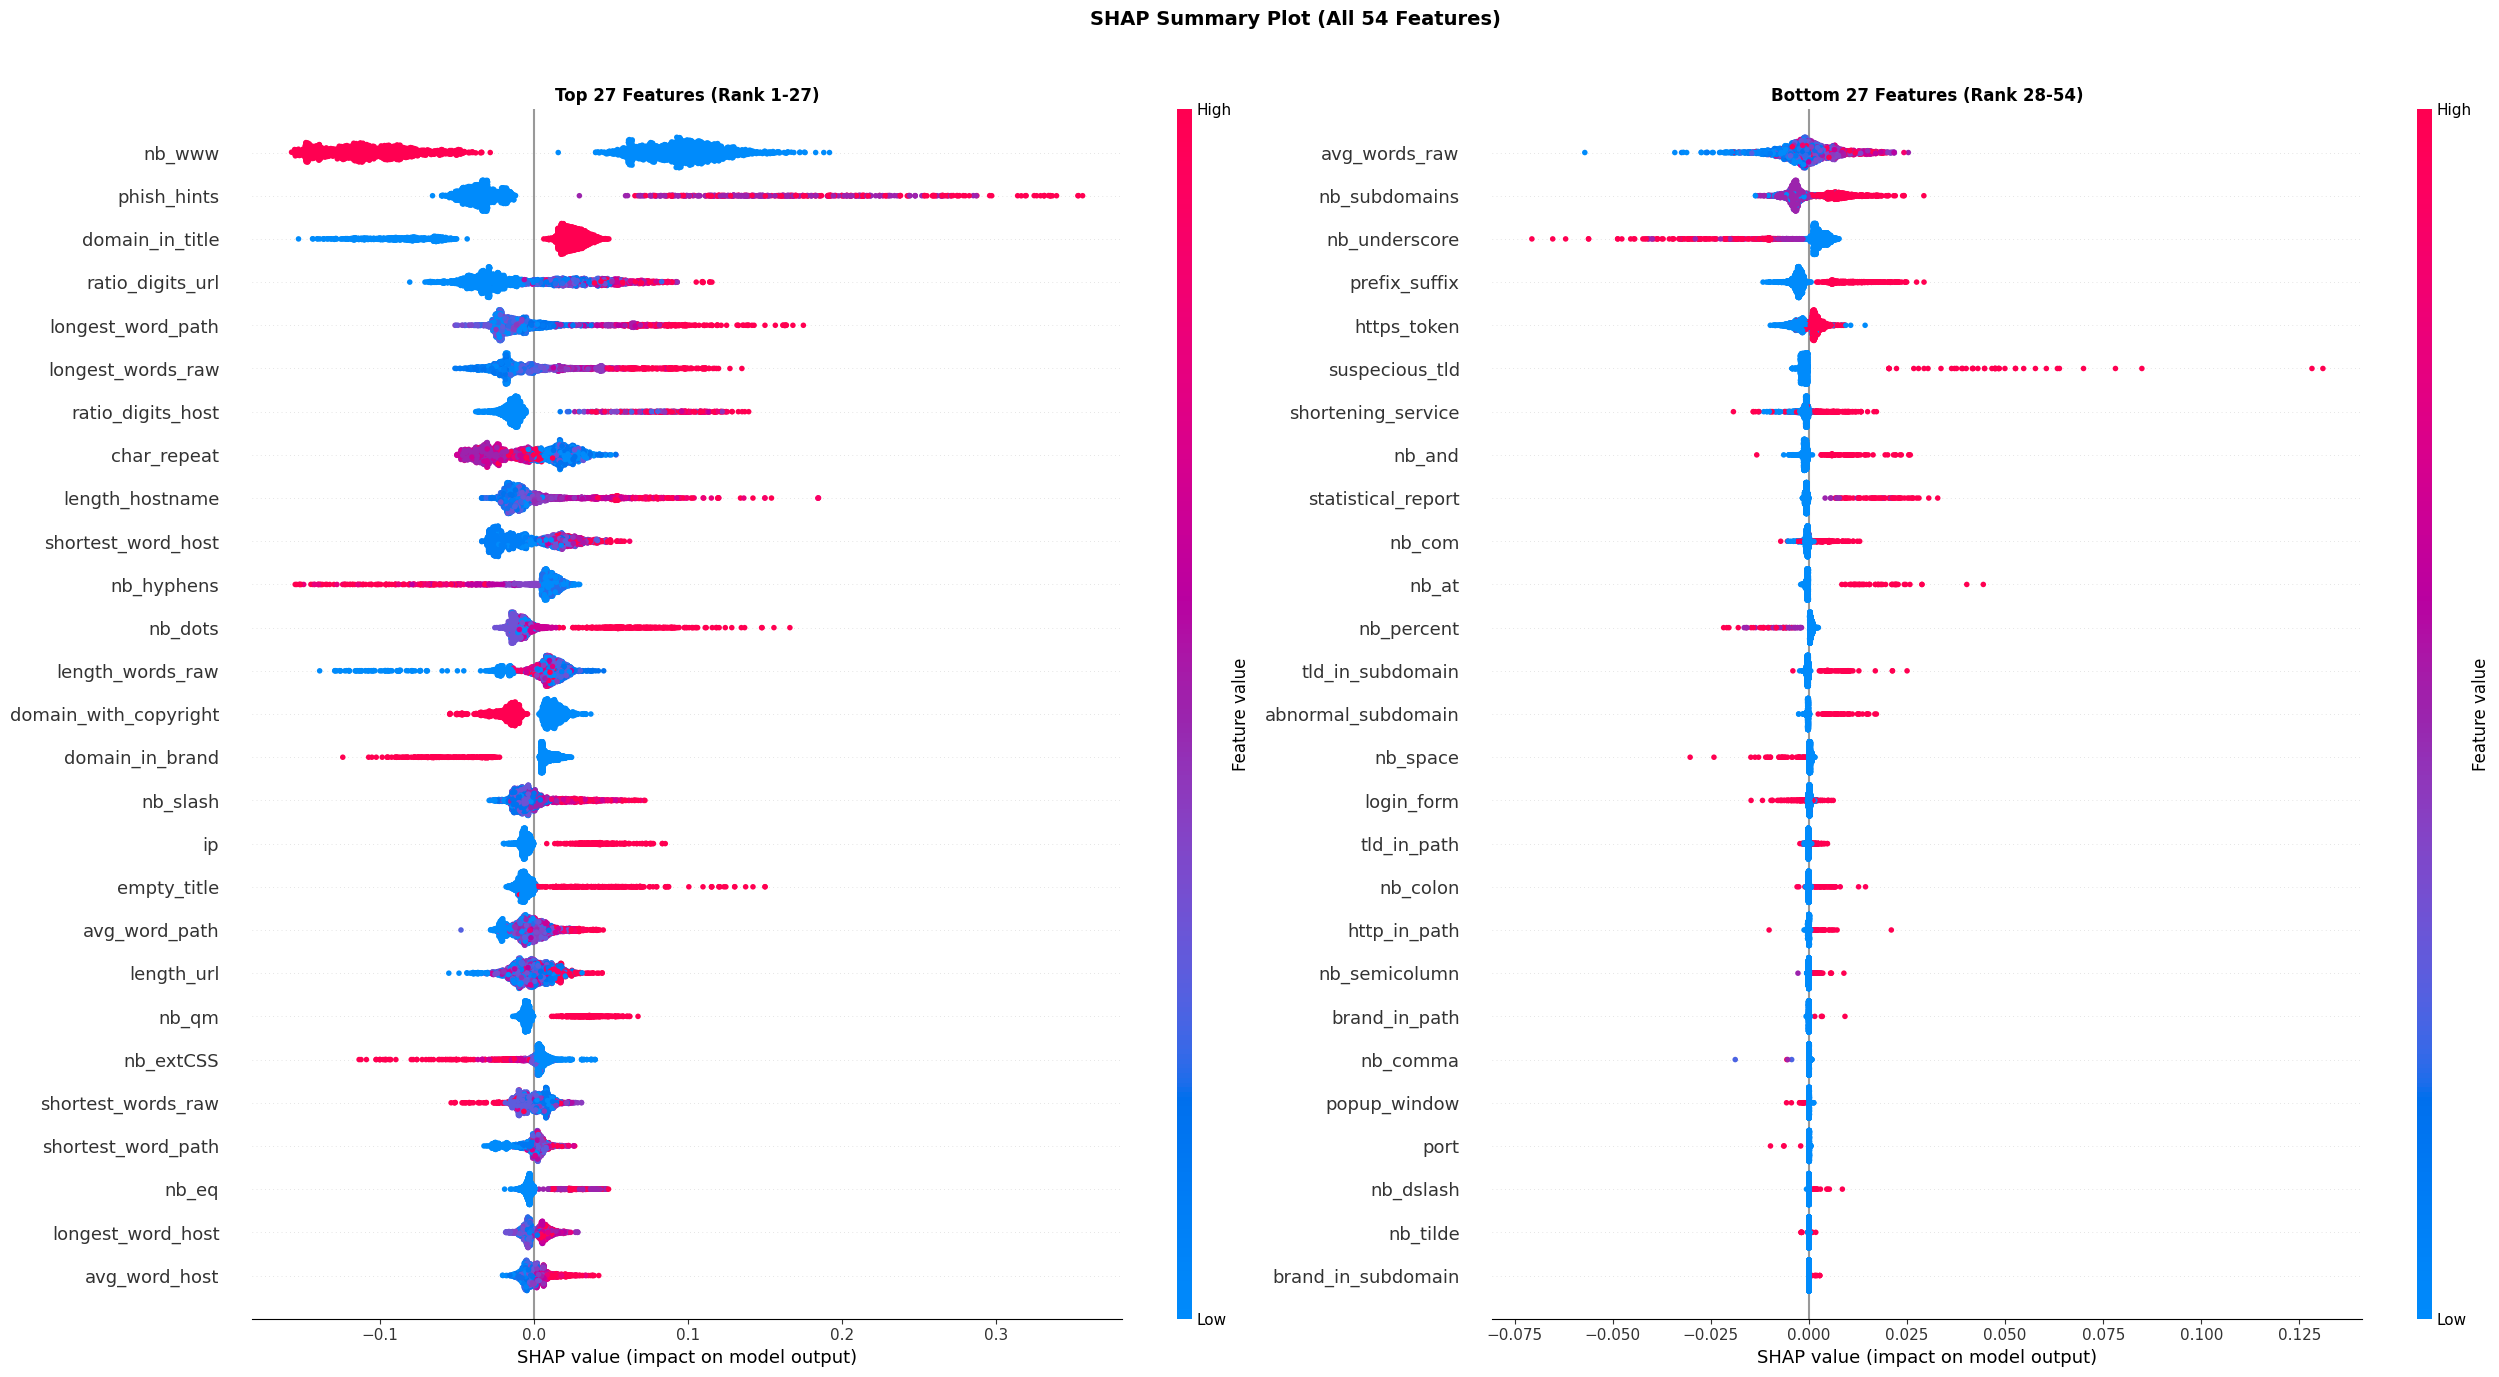


📊 Top 10 중요 피처:
  1. nb_www: 0.1017
  2. phish_hints: 0.0580
  3. domain_in_title: 0.0391
  4. ratio_digits_url: 0.0328
  5. longest_word_path: 0.0248
  6. longest_words_raw: 0.0242
  7. ratio_digits_host: 0.0237
  8. char_repeat: 0.0216
  9. length_hostname: 0.0194
  10. shortest_word_host: 0.0194

📊 해석 가이드:
  - 빨간점(높은 피처 값)이 오른쪽(+)에 위치 → 높은 값이 피싱 예측 증가
  - 파란점(낮은 피처 값)이 왼쪽(-)에 위치 → 낮은 값이 정상 예측 증가
  - 점들의 밀도가 높을수록 해당 SHAP 값에 많은 샘플이 분포


In [20]:
# ===== 10) SHAP Summary Plot (논문용 투컬럼) =====
import shap
import matplotlib.pyplot as plt
import os

OUTPUT_DIR = "/home/yu_mcc/QR_Phishing/phishing"

print("="*70)
print("SHAP Summary Plot (54 Features - 논문용 투컬럼)")
print("="*70)

# SHAP 값은 이미 2D (TreeExplainer는 직접 2D 반환)
print(f"SHAP values shape: {shap_values.shape}")
shap_values_2d = shap_values

# 피처 중요도 순서로 정렬
mean_abs_shap = np.mean(np.abs(shap_values_2d), axis=0).flatten()
sorted_idx = np.argsort(mean_abs_shap)[::-1]  # 중요도 높은 순

# 54개를 27개씩 나누기
n_features = len(feature_names)
half = n_features // 2  # 27개

top_idx = sorted_idx[:half]  # 상위 27개
bottom_idx = sorted_idx[half:]  # 하위 27개

# 투컬럼 그래프 생성
fig, axes = plt.subplots(1, 2, figsize=(26, 14))

for ax, indices, title in zip(axes, [top_idx, bottom_idx], 
                               ['Top 27 Features (Rank 1-27)', 'Bottom 27 Features (Rank 28-54)']):
    # 해당 피처만 추출
    shap_subset = shap_values_2d[:, indices]
    X_subset = X_test_sample[:, indices]
    feature_subset = [feature_names[i] for i in indices]
    
    plt.sca(ax)
    shap.summary_plot(
        shap_subset, 
        X_subset, 
        feature_names=feature_subset,
        max_display=27,
        show=False,
        plot_size=None
    )
    ax.set_title(title, fontsize=12, fontweight='bold')

plt.suptitle('SHAP Summary Plot (All 54 Features)', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 저장
dot_plot_path = os.path.join(OUTPUT_DIR, 'shap_summary_twocolumn.png')
plt.savefig(dot_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {dot_plot_path}")
plt.show()

# Top 10 피처 출력
print(f"\n📊 Top 10 중요 피처:")
for i, idx in enumerate(sorted_idx[:10]):
    print(f"  {i+1}. {feature_names[idx]}: {mean_abs_shap[idx]:.4f}")

print("\n" + "="*70)
print("📊 해석 가이드:")
print("="*70)
print("  - 빨간점(높은 피처 값)이 오른쪽(+)에 위치 → 높은 값이 피싱 예측 증가")
print("  - 파란점(낮은 피처 값)이 왼쪽(-)에 위치 → 낮은 값이 정상 예측 증가")
print("  - 점들의 밀도가 높을수록 해당 SHAP 값에 많은 샘플이 분포")